Getting started
===============
In this part we are going to show you how to run a program on a GPU, this is
done using an example program, which is converted in a few steps to run on the
GPU. The example program we are going to look at calculates the Mandelbrot set.

0 Sequential implementation
---------------------------
The sequential version contains a function called `mandelbrot`, which is all the
logic we need to calculate the Mandelbrot set.
```python
def mandelbrot(z, max_iterations):
    c = z
    for i in xrange(max_iterations):
        if abs(z) > 2:
            return i
        z = z*z + c
    return max_iterations
```
It takes a complex number `z` and a maximum number of iterations to be run.

To setup the function we have a lot of variables with default values defining
width and height of the image we are generating, how many iterations should at
most be run in the `mandelbrot` function, and which area of the fractal should
be shown (default is everything).

It then creates two arrays, `reals` and `imaginaries`, with an even spread of
numbers from between the mins and maxes described above. These numbers are used
as the real and imaginary parts of the complex numbers we are doing our
calculations on.

The Mandelbrot set is then calculated for each combination of the two arrays.
```python
for i in xrange(width):
    for j in xrange(height):
        res[i, j] = mandelbrot(complex(reals[j], imaginaries[i]), max_iterations)
```

In [1]:
import math
import numpy as np
import time

def mandelbrot(z, max_iterations):
    c = z
    for i in range(max_iterations):
        if abs(z) > 2:
            return i
        z = z*z + c
    return max_iterations

width = 1000
height = 1000
max_iterations = 100
xmin = -2.5
xmax = 1.5
ymin = -2.0
ymax = 2.0
start_time = time.time()
reals = np.linspace(xmin, xmax, width)
imaginaries = np.linspace(ymax, ymin, height)
res = np.empty((width, height))

for i in range(width):
    for j in range(height):
        res[i, j] = mandelbrot(complex(reals[j], imaginaries[i]), max_iterations)
total_time_seq = time.time() - start_time

1 Before we start
-----------------
Before we start converting the program into CUDA, we need to lay some
groundwork. We need to understand how to make the program run on the GPU and how
to get our data to and from it.

First of all, we need to import some modules.
```python
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
```

To get our code onto the GPU, we need to use the imported `SourceModule`
function, where the argument to the function is the code, we want to run.
The code is written in a C++-like langauge with some added features. Kernels, as
the functions running on GPUs are called, have `__global__` before their return
type and name. The return type will always be `void` because these functions
does not return anything. Instead the data is copied to and from the GPU.
```python
mod = SourceModule("""
        __global__ void SomeKernel(
            const float *readOnlyArgument,
            float *writeOnlyArgument,
            float someConstant)
        {
            int i = blockIdx.x*blockDim.x+threadIdx.x;
        }
        """)
```
With the code above we see three variables, blockIdx, blockDim, and threadIdx,
that we have not defined. These will be instantiated when we are running and
tell us know where we are running. When running our code, it is run in a grid of
thread block. Each thread block can have up to 1024 threads and must be a power
of 2.

To run our code, we first need to get our function from the module. This is done
using the `get_function` method on our module. When running the function we can
specify which arrays should be copied to and from the GPU by using the
`cuda.In`, `cuda.Out`, and `cuda.InOut` methods. We also need to define the
dimensions of our blocks and grid, where the grid is defined as the number of
thread blocks in each dimension.
```python
some_kernel = mod.get_function("SomeKernel")
some_kernel(
    cuda.In(read_only_data),
    cuda.Out(write_only_data),
    np.float32(some_constant),
    np.int16(block_size),
    block = block_dimensions,
    grid=grid_size)
```

2 Naïve implementation
----------------------
In this version we have taken the naïve approach and done a direct translation
of the program. To use the library for complex arithmetic, we start by writing
`#include "cuComplex.h"`. This enables us to use the type `cuFloatComplex`, and
the functions `cuCmulf` (multiplication of complex numbers) and `cuCaddf`
(addition of complex numbers). Underneath the `cuFloatComplex` type is a vector
type called `float2`, a 2D floating point vector. CUDA has multiple types, which
support vector types, those are char, uchar, short, ushort, int, uint,
long, ulong, longlong, ulonglong, float, and double. The length of the vector
types can be 2, 3, and 4.

The only translation we have done in this version is the `mandelbrot`
function and the complex arithmetic, which means all data is still generated and
sent from the host. But looking at the function we see, that we have to send the
width and height to the function is because we are running in thread blocks, as
described earlier. We could end up out of bounds of our array, which we do not
want and therefore we have this `if`-statement.

In [2]:
import numpy as np
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import math
import time

mod = SourceModule("""
        #include "cuComplex.h"

        __global__ void mandelbrot(
            const cuFloatComplex *zs,
            int *res,
            ushort width,
            ushort height,
            ushort max_iterations)
        {
            int x = blockIdx.x*blockDim.x+threadIdx.x;
            int y = blockIdx.y*blockDim.y+threadIdx.y;

            if (x < width && y < height) {
                cuFloatComplex z = zs[y*width+x];
                cuFloatComplex c = z;

                for (int i = 0; i < max_iterations; i++) {
                    if (z.x*z.x + z.y*z.y <= 4.0f) {
                        res[y*width+x] = i+1;
                        z = cuCmulf(z, z);
                        z = cuCaddf(z, c);
                    }
                }
            }
        }
        """)

width = 1000
height = 1000
max_iterations = 100
xmin = -2.5
xmax = 1.5
ymin = -2.0
ymax = 2.0
start_time = time.time()
reals = np.linspace(xmin, xmax, width)
imaginaries = np.linspace(ymax, ymin, height) * 1j

zs = (reals+imaginaries[:, np.newaxis]).flatten().astype(np.complex64)

res = np.empty(width*height).astype(np.int32)

if width > 512:
    dim_size = 32
else:
    dim_size = 16
block_size = (dim_size,dim_size,1)

# Assuming width == height
grids_needed = int(math.ceil(width / float(dim_size)))
grid_size = (grids_needed, grids_needed)

mandelbrot = mod.get_function("mandelbrot")
mandelbrot(
        cuda.In(zs),
        cuda.Out(res),
        np.uint16(width),
        np.uint16(height),
        np.uint16(max_iterations),
        block=block_size,
        grid=grid_size)

# Setting shape of array to help displaying it
res.shape = (width, height)
total_time_naive = time.time() - start_time

3 Less transfer implementation
------------------------------
Transferring data to and from the GPU takes time, which in turn makes our
calculations slower. So we should try to limit how much data we move around.
In the naïve version we generate our data on the host and create a 1000 by 1000
matrix, which is then transfered to the GPU. But we can be smarter than that.
By sending our lists of real and imaginary parts, we can then combine them on
the GPU saving both time and space, because we already have the coordinates of
from our two global ids.

In [12]:
import numpy as np
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import math
import time

mod = SourceModule("""
        #include "cuComplex.h"

        __global__ void mandelbrot(
            const float *re,
            const float *im,
            int *res,
            ushort width,
            ushort height,
            ushort max_iterations)
        {
            int x = blockIdx.x*blockDim.x+threadIdx.x;
            int y = blockIdx.y*blockDim.y+threadIdx.y;

            if (x < width && y < height) {
                cuFloatComplex z = make_cuFloatComplex(re[x], im[y]);
                cuFloatComplex c = z;

                for (int i = 0; i < max_iterations; i++) {
                    if (z.x*z.x + z.y*z.y <= 4.0f) {
                        res[y*width+x] = i+1;
                        z = cuCmulf(z, z);
                        z = cuCaddf(z, c);
                    }
                }
            }
        }
        """)

width = 1000
height = 1000
max_iterations = 100
xmin = -2.5
xmax = 1.5
ymin = -2.0
ymax = 2.0

start_time = time.time()
reals = np.linspace(xmin, xmax, width).astype(np.float32)
imaginaries = np.linspace(ymax, ymin, height).astype(np.float32)
res = np.empty(width*height).astype(np.int32)

if width > 512:
    dim_size = 32
else:
    dim_size = 16
block_size = (dim_size,dim_size,1)

# Assuming width == height
grids_needed = int(math.ceil(width / float(dim_size)))
grid_size = (grids_needed, grids_needed)

mandelbrot = mod.get_function("mandelbrot")
mandelbrot(
        cuda.In(reals),
        cuda.In(imaginaries),
        cuda.Out(res),
        np.uint16(width),
        np.uint16(height),
        np.uint16(max_iterations),
        block=block_size,
        grid=grid_size)

# Setting shape of array to help displaying it
res.shape = (width, height)
total_time_less_transfer = time.time() - start_time

4 GPU only implementation
-------------------------
In this implementation we move the data generation to the GPU. This removes data
transfer to the GPU completely, which should reduce total computation time
considerably, especially when calculating with a higher resolution. Of course we
still need to transfer the result array from the GPU, which is the majority of
our data transfer, but reducing data transfer should be a priority.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import math
import time

mod = SourceModule("""
        #include "cuComplex.h"

        __global__ void mandelbrot(
            int *res,
            ushort width,
            ushort height,
            float xmin,
            float xmax,
            float ymin,
            float ymax,
            ushort max_iterations)
        {
            int x = blockIdx.x*blockDim.x+threadIdx.x;
            int y = blockIdx.y*blockDim.y+threadIdx.y;
            float widthf = width - 1.0f;
            float heightf = height - 1.0f;

            if (x < width && y < height) {
                cuFloatComplex z = make_cuFloatComplex(
                    xmin + ((xmax-xmin)*x/widthf),
                    ymax - ((ymax-ymin)*y/heightf));
                cuFloatComplex c = z;

                for (int i = 0; i < max_iterations; i++) {
                    if (z.x*z.x + z.y*z.y <= 4.0f) {
                        res[y*width+x] = i+1;
                        z = cuCmulf(z, z);
                        z = cuCaddf(z, c);
                    }
                }
            }
        }
        """)


width = 1000
height = 1000
max_iterations = 100
xmin = -2.5
xmax = 1.5
ymin = -2.0
ymax = 2.0
start_time = time.time()
res = np.empty(width*height).astype(np.int32)

if width > 512:
    dim_size = 32
else:
    dim_size = 16
block_size = (dim_size,dim_size,1)

# Assuming width == height
grids_needed = int(math.ceil(width / float(dim_size)))
grid_size = (grids_needed, grids_needed)

mandelbrot = mod.get_function("mandelbrot")
mandelbrot(
        cuda.Out(res),
        np.uint16(width),
        np.uint16(height),
        np.float32(xmin),
        np.float32(xmax),
        np.float32(ymin),
        np.float32(ymax),
        np.uint16(max_iterations),
        block=block_size,
        grid=grid_size)

# Setting shape of array to help displaying it
res.shape = (width, height)
total_time_gpu_only = time.time() - start_time

Visualizer
-----------

The code below here can be run after any of the codes above and it will visualize the mandlebrot being calculated.

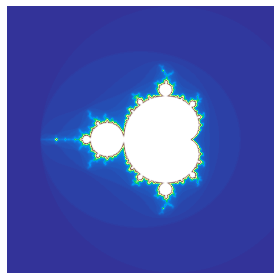

In [10]:
import matplotlib.pyplot as plt
# Displaying the Mandelbrot set
fig, ax = plt.subplots()

plt.imshow(res, interpolation='bicubic', cmap=plt.get_cmap("terrain"))
plt.axis("off")
plt.tight_layout()

plt.show()

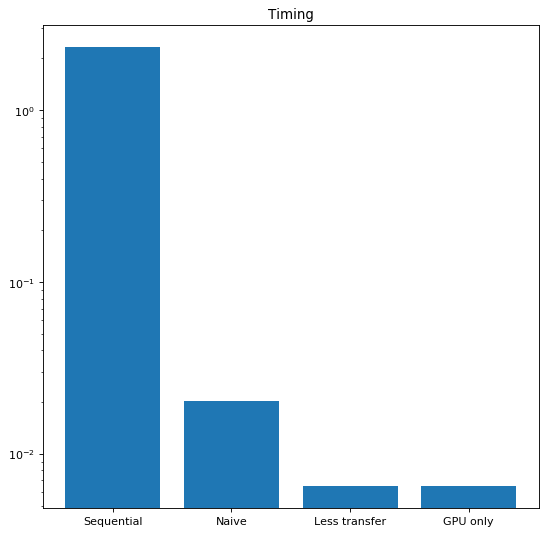

In [13]:
import matplotlib.pyplot as plt
names = ["Sequential", "Naive", "Less transfer", "GPU only"]
values = [total_time_seq, total_time_naive, total_time_less_transfer, total_time_gpu_only]

fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.title("Timing")
plt.bar(names, values)
plt.yscale("log")

plt.show()